##Importing Libraries and Data

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product

from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')
import datetime

In [ ]:
df_prophet = pd.read_csv('energydata_complete.csv')

Changing the data to include hourly increments

In [ ]:
df_prophet = df_prophet[::6]

## Exploratory Data Analysis

In [ ]:
df_prophet.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333



Dropping Irrelevant Columns

In [ ]:
drop_cols = ['lights', 'rv1', 'rv2']
df_prophet = df_prophet.drop(drop_cols, axis=1)

In [ ]:
df_prophet.shape

(3290, 26)

## Prophet Model

In [ ]:
!pip install prophet

from prophet import Prophet

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_weekly

In [ ]:
m = Prophet()

In [ ]:
df_prophet = df_prophet[['date', 'Appliances']]

In [ ]:
df_prophet.columns = ['ds', 'y']

Hyperparameter Tuning

In [ ]:
df_prophet.head()

,ds,y
0,2016-01-11 17:00:00,60
6,2016-01-11 18:00:00,60
12,2016-01-11 19:00:00,430
18,2016-01-11 20:00:00,80
24,2016-01-11 21:00:00,110


In [ ]:
df_prophet.tail()

,ds,y
19710,2016-05-27 14:00:00,190
19716,2016-05-27 15:00:00,60
19722,2016-05-27 16:00:00,100
19728,2016-05-27 17:00:00,110
19734,2016-05-27 18:00:00,430


In [ ]:
param_grid = {
    'changepoint_prior_scale' : [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale' : [0.01, 0.1, 1.0, 10]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

rmses = []

cutoff = pd.date_range(start = '2016-02-11', end = '2016-05-26', freq = 'H')

for params in all_params:
  m = Prophet(**params)
  m.add_country_holidays(country_name='US')
  m.fit(df_prophet)
  df_cv = cross_validation(m, horizon = '24 hours', cutoffs = cutoff)
  df_p = performance_metrics(df_cv, rolling_window=1)
  rmses.append(df_p['rmse'].values[0])

In [ ]:
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

best_params = all_params(np.argmin(rmses))
print(best_params)

Fit the best model

In [ ]:
m = Prophet(
    changepoint_prior_scale = 0.01,
    seasonality_prior_scale = 0.1,
)

m.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptiw807zy/r9xqp41x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptiw807zy/q7q777s_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10920', 'data', 'file=/tmp/tmptiw807zy/r9xqp41x.json', 'init=/tmp/tmptiw807zy/q7q777s_.json', 'output', 'file=/tmp/tmptiw807zy/prophet_modelss7tosum/prophet_model-20230703142849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:28:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Making future forecasts

In [ ]:
future = m.make_future_dataframe(periods=24, freq = 'H')
future.tail()

,ds
3309,2016-05-28 14:00:00
3310,2016-05-28 15:00:00
3311,2016-05-28 16:00:00
3312,2016-05-28 17:00:00
3313,2016-05-28 18:00:00


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3309,2016-05-28 14:00:00,111.319858,-4.479629,225.575700
3310,2016-05-28 15:00:00,102.471410,-19.610919,218.119809
3311,2016-05-28 16:00:00,111.239357,3.035174,225.342458
3312,2016-05-28 17:00:00,134.841441,13.006429,248.594686
3313,2016-05-28 18:00:00,158.019374,42.194850,275.319720


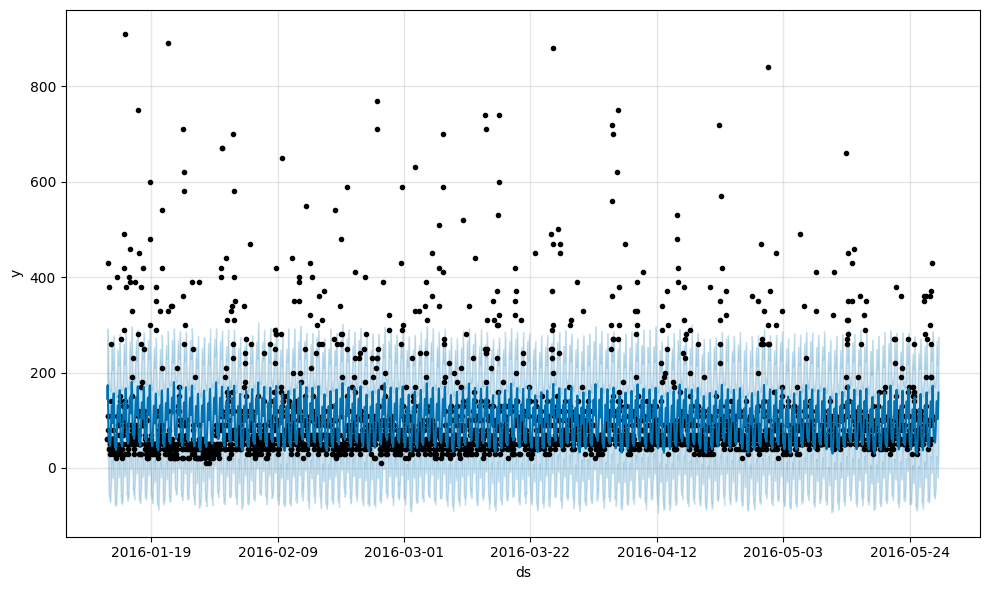

In [ ]:
forecast_fig = m.plot(forecast)


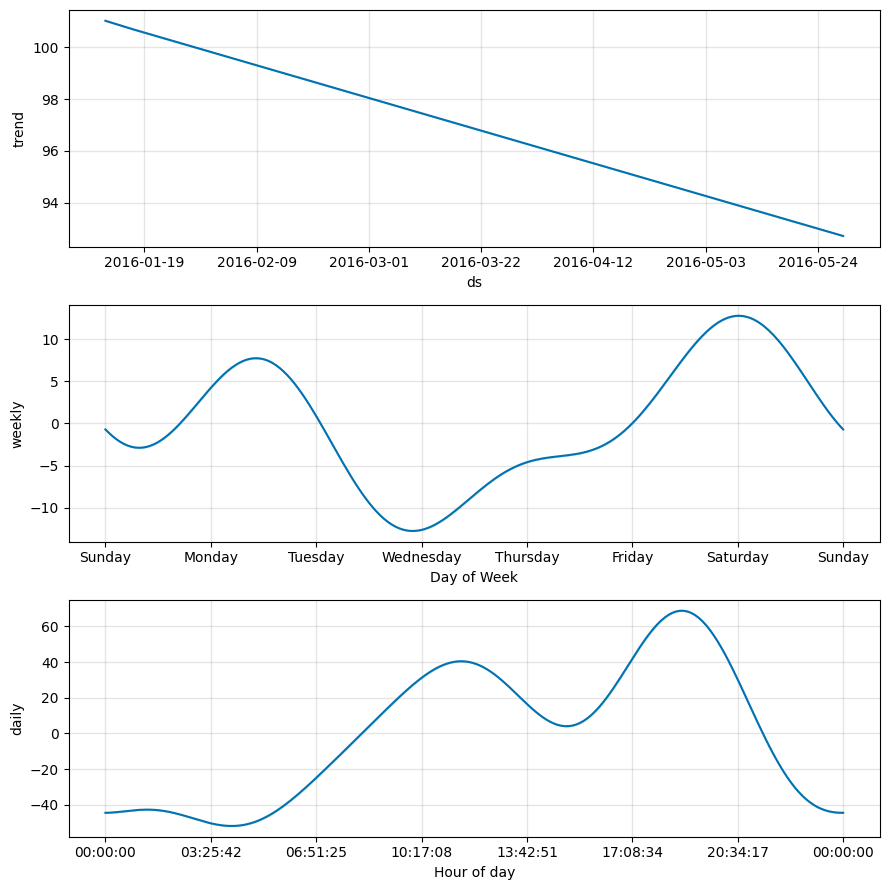

In [ ]:
components_fig = m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

Performance

In [ ]:
cutoff = pd.date_range(start = '2016-02-11', end = '2016-05-26', freq = 'H')

In [ ]:
df_cv = cross_validation(m, initial='48 hours', period='12 hours', horizon = '24 hours', cutoffs = cutoff)
df_p = performance_metrics(df_cv)

fig = plot_cross_validation_metric(df_cv, metric = 'mape')

  0%|          | 0/2521 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80229', 'data', 'file=/tmp/tmptiw807zy/fjqnpjmq.json', 'init=/tmp/tmptiw807zy/g6vhm9fx.json', 'output', 'file=/tmp/tmptiw807zy/prophet_modelga4w9t2g/prophet_model-20230703144028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptiw807zy/gpcy9w6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptiw807zy/_x54mya0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random

KeyboardInterrupt: ignored